In [2]:
%matplotlib inline

import tensorflow
import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np

In [3]:
# directory where images are stored
DIR = "./flower_images"

def dataset_stats():
    
    # This is an array with the letters available.
    # If you add another animal later, you will need to structure its images in the same way
    # and add its letter to this array
    condition_characters = ['F']
    
    # dictionary where we will store the stats
    stats = []
    
    for condition in condition_characters:
        # get a list of subdirectories that start with this character
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, condition)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({ "Code": sub_directory_name[:sub_directory_name.find('-')],
                            "Image count": file_count, 
                           "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    
    df = pd.DataFrame(stats)
    
    return df

In [4]:
# Show codes with their folder names and image counts
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

,Folder name,Image count
Code,,
F1,F1-Daisy,200
F2,F2-Dandelion,200
F3,F3-Rose,200
F4,F4-Sunflower,200
F5,F5-Tulip,200


In [5]:
# Function returns an array of images whoose filenames start with a given set of characters
# after resizing them to 224 x 224

def load_images(codes):
    
    # Define empty arrays where we will store our images and labels
    images = []
    labels = []
    
    for code in codes:
        # get the folder name for this code
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # build file path
            file_path = os.path.join(DIR, folder_name, file)
        
            # Read the image
            image = cv2.imread(file_path)

            # Resize it to 224 x 224
            image = cv2.resize(image, (224,224))

            # Convert it from BGR to RGB so we can plot them later (because openCV reads images as BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Now we add it to our array
            images.append(image)
            labels.append(code)

    return images, labels

In [6]:
codes = ["F1","F4"]
images, labels = load_images(codes)

In [7]:
def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for code F1


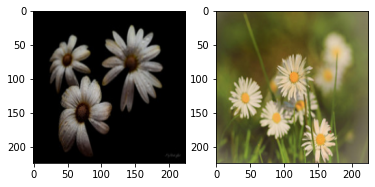

2 random images for code F4


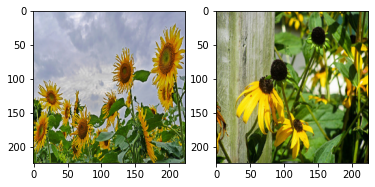

In [8]:
show_random_images(images, labels)

In [9]:
def normalise_images(images, labels):

    # Convert to numpy arrays
    images = np.array(images, dtype=np.float32)
    labels = np.array(labels)

    # Normalise the images
    images /= 255
    
    return images, labels

In [10]:
images, labels = normalise_images(images, labels)

In [11]:
def shuffle_data(images, labels):

    # Set aside the testing data. We won't touch these until the very end.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=728)
    
    return X_train, y_train

In [12]:
X_train, y_train = shuffle_data(images, labels)

In [13]:
# Load the models with ImageNet weights

vgg16_model = tensorflow.keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

vgg19_model = tensorflow.keras.applications.vgg19.VGG19(include_top=False, weights="imagenet", input_shape=(224,224,3))

resnet50_model = tensorflow.keras.applications.resnet50.ResNet50(include_top=False, weights="imagenet", input_shape=(224,224,3))


In [14]:
def covnet_transform(covnet_model, raw_images):

    # Pass our training data through the network
    pred = covnet_model.predict(raw_images, batch_size = 1)

    # Flatten the array
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat


In [16]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

vgg19_output = covnet_transform(vgg19_model, X_train)
print("VGG19 flattened output has {} features".format(vgg19_output.shape[1]))

resnet50_output = covnet_transform(resnet50_model, X_train)
print("ResNet50 flattened output has {} features".format(resnet50_output.shape[1]))

VGG16 flattened output has 25088 features
VGG19 flattened output has 25088 features
ResNet50 flattened output has 100352 features


In [17]:
# Function that creates a PCA instance, fits it to the data and returns the instance
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p
    

In [18]:
# Create PCA instances for each covnet output
vgg16_pca = create_fit_PCA(vgg16_output)
vgg19_pca = create_fit_PCA(vgg19_output)
resnet50_pca = create_fit_PCA(resnet50_output)


In [19]:
# Function to plot the cumulative explained variance of PCA components
# This will help us decide how many components we should reduce our features to
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

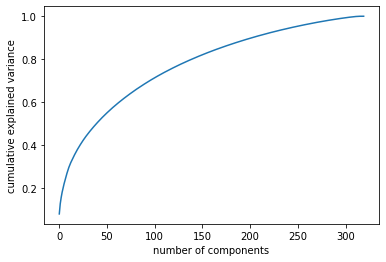

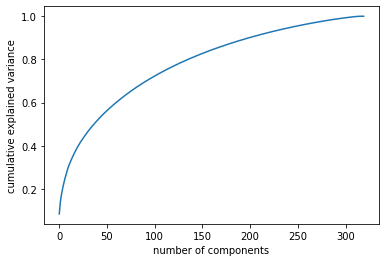

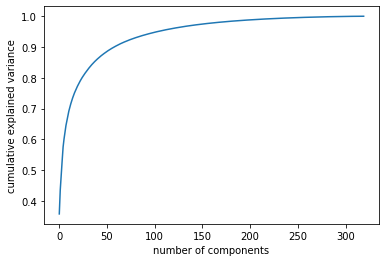

In [20]:
# Plot the cumulative explained variance for each covnet
pca_cumsum_plot(vgg16_pca)
pca_cumsum_plot(vgg19_pca)
pca_cumsum_plot(resnet50_pca)

In [21]:
# PCA transformations of covnet outputs
vgg16_output_pca = vgg16_pca.transform(vgg16_output)
vgg19_output_pca = vgg19_pca.transform(vgg19_output)
resnet50_output_pca = resnet50_pca.transform(resnet50_output)

In [22]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    # n_jobs is set to -1 to use all available CPU cores. This makes a big difference on an 8-core CPU
    # especially when the data size gets much bigger. #perfMatters
    
    k = KMeans(n_clusters=number_of_clusters, n_jobs=-1, random_state=728)

    # Let's do some timings to see how long it takes to train.
    start = time.time()

    # Train it up
    k.fit(data)

    # Stop the timing 
    end = time.time()

    # And see how long that took
    print("Training took {} seconds".format(end-start))
    
    return k

In [23]:
def create_train_gmm(data, number_of_clusters=len(codes)):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g
    

In [24]:
# Let's pass the data into the algorithm and predict who lies in which cluster. 
# Since we're using the same data that we trained it on, this should give us the training results.

# Here we create and fit a KMeans model with the PCA outputs
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

print("\nVGG19")
K_vgg19_pca = create_train_kmeans(vgg19_output_pca)

print("\nResNet50")
K_resnet50_pca = create_train_kmeans(resnet50_output_pca)

KMeans (PCA): 

VGG16
Training took 0.18169450759887695 seconds

VGG19


c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.07827520370483398 seconds

ResNet50
Training took 0.06240439414978027 seconds


c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [25]:
# Same for Gaussian Model
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

print("\nVGG19")
G_vgg19_pca = create_train_gmm(vgg19_output_pca)

print("\nResNet50")
G_resnet50_pca = create_train_gmm(resnet50_output_pca)


GMM (PCA): 

VGG16
Training took 0.09659838676452637 seconds

VGG19
Training took 0.07829856872558594 seconds

ResNet50
Training took 0.07208609580993652 seconds


In [26]:
# Let's also create models for the covnet outputs without PCA for comparison
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)

print("\nVGG19:")
K_vgg19 = create_train_kmeans(vgg19_output)

print("\nResNet50:")
K_resnet50 = create_train_kmeans(resnet50_output)


KMeans: 

VGG16:


c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 2.716459035873413 seconds

VGG19:


c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 6.668148517608643 seconds

ResNet50:


c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 12.234424114227295 seconds


In [27]:
# Now we get the custer model predictions

# KMeans with PCA outputs
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)
k_vgg19_pred_pca = K_vgg19_pca.predict(vgg19_output_pca)
k_resnet50_pred_pca = K_resnet50_pca.predict(resnet50_output_pca)

# KMeans with CovNet outputs
k_vgg16_pred = K_vgg16.predict(vgg16_output)
k_vgg19_pred = K_vgg19.predict(vgg19_output)
k_resnet50_pred = K_resnet50.predict(resnet50_output)

# Gaussian Mixture with PCA outputs
g_resnet50_pred_pca = G_resnet50_pca.predict(resnet50_output_pca)
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)
g_vgg19_pred_pca = G_vgg19_pca.predict(vgg19_output_pca)

In [28]:
def cluster_label_count(clusters, labels):
    
    count = {}
    
    # Get unique clusters and labels
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Create counter for each cluster/label combination and set it to 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Let's count
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [29]:
# Cluster counting for VGG16 Means
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# VGG19 KMeans
vgg19_cluster_count = cluster_label_count(k_vgg19_pred, y_train)
vgg19_cluster_count_pca = cluster_label_count(k_vgg19_pred_pca, y_train)

# ResNet50 KMeans
resnet_cluster_count = cluster_label_count(k_resnet50_pred, y_train)
resnet_cluster_count_pca = cluster_label_count(k_resnet50_pred_pca, y_train)

# GMM
g_vgg16_cluster_count_pca = cluster_label_count(g_vgg16_pred_pca, y_train)
g_vgg19_cluster_count_pca = cluster_label_count(g_vgg19_pred_pca, y_train)
g_resnet50_cluster_count_pca = cluster_label_count(g_resnet50_pred_pca, y_train)

In [30]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


,0,1
F1,60,106
F4,61,93


In [31]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


,0,1
F1,60,106
F4,61,93


In [32]:
print("GMM VGG16: ")
g_vgg16_cluster_count_pca

GMM VGG16: 


,0,1
F1,98,68
F4,73,81


In [33]:
print("KMeans VGG19: ")
vgg19_cluster_count

KMeans VGG19: 


,0,1
F1,107,59
F4,82,72


In [34]:
print("KMeans VGG19 (PCA): ")
vgg19_cluster_count_pca

KMeans VGG19 (PCA): 


,0,1
F1,107,59
F4,82,72


In [35]:
print("GMM VGG19 (PCA): ")
g_vgg19_cluster_count_pca

GMM VGG19 (PCA): 


,0,1
F1,91,75
F4,71,83


In [36]:
print("KMeans Resnet50: ")
resnet_cluster_count

KMeans Resnet50: 


,0,1
F1,107,59
F4,131,23


In [37]:
print("Kmeans Resnet50 (PCA): ")
resnet_cluster_count_pca

Kmeans Resnet50 (PCA): 


,0,1
F1,107,59
F4,131,23


In [38]:
print("GMM Resnet50 (PCA): ")
g_resnet50_cluster_count_pca

GMM Resnet50 (PCA): 


,0,1
F1,105,61
F4,131,23


In [39]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
resnet_cluster_code = ["F4", "F1"]
resnet_cluster_code_pca = ["F4", "F1"]

vgg19_cluster_code = ["F1", "F4"]
vgg19_cluster_code_pca = ["F1", "F4"]
# g_vgg19_cluster_code_pca = ["D25", "D19", "C8", "C1"]



In [40]:
resnet50_pred_codes = [resnet_cluster_code[x] for x in k_resnet50_pred]
resnet50_pred_codes_pca = [resnet_cluster_code_pca[x] for x in k_resnet50_pred_pca]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in k_vgg19_pred]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in k_vgg19_pred_pca]
# g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in g_vgg19_pred_pca]


In [41]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(y_train, resnet50_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, resnet50_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(y_train, vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(y_train, vgg19_pred_codes_pca))
# print("GMM VGG19 (PCA)", print_scores(y_train, g_vgg19_pred_codes_pca))


KMeans VGG16: 
	F1 Score: 0.57208690   |   Accuracy: 0.57208690
KMeans VGG16 (PCA) 
	F1 Score: 0.57208690   |   Accuracy: 0.57208690

KMeans VGG19:  
	F1 Score: 0.55404003   |   Accuracy: 0.55404003
KMeans VGG19 (PCA):  
	F1 Score: 0.55404003   |   Accuracy: 0.55404003


In [42]:
# Let's put it all together

def all_covnet_transform(data):
    vgg16 = covnet_transform(vgg16_model, data)
    vgg19 = covnet_transform(vgg19_model, data)
    resnet50 = covnet_transform(resnet50_model, data)
    
    return vgg16, vgg19, resnet50


def image_load_to_cluster_count(codes):
    # Load images
    images, labels = load_images(codes)
    print(len(images), len(labels))
    show_random_images(images, labels)
    
    # Normalise images
    images, labels = normalise_images(images, labels)
    
    # Split data
    data, labels = shuffle_data(images, labels)
    
    # Get covnet outputs
    vgg16_output, vgg19_output, resnet50_output = all_covnet_transform(data)
    
    # Get PCA transformations
    vgg16_output_pca = create_fit_PCA(vgg16_output).transform(vgg16_output)
    vgg19_output_pca = create_fit_PCA(vgg19_output).transform(vgg19_output)
    resnet50_output_pca = create_fit_PCA(resnet50_output).transform(resnet50_output)
    
    # Cluster
    clusters = len(codes)
    
    K_vgg16_pred = create_train_kmeans(vgg16_output, clusters).predict(vgg16_output)
    K_vgg19_pred = create_train_kmeans(vgg19_output, clusters).predict(vgg19_output)
    K_resnet50_pred = create_train_kmeans(resnet50_output, clusters).predict(resnet50_output)
    K_vgg16_pred_pca = create_train_kmeans(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    K_vgg19_pred_pca = create_train_kmeans(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    K_resnet50_pred_pca = create_train_kmeans(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    G_vgg16_pred_pca = create_train_gmm(vgg16_output_pca, clusters).predict(vgg16_output_pca)
    G_vgg19_pred_pca = create_train_gmm(vgg19_output_pca, clusters).predict(vgg19_output_pca)
    G_resnet50_pred_pca = create_train_gmm(resnet50_output_pca, clusters).predict(resnet50_output_pca)
    
    # Count
    vgg16_cluster_count = cluster_label_count(K_vgg16_pred, labels)
    vgg16_cluster_count_pca = cluster_label_count(K_vgg16_pred_pca, labels)

    # VGG19 KMeans
    vgg19_cluster_count = cluster_label_count(K_vgg19_pred, labels)
    vgg19_cluster_count_pca = cluster_label_count(K_vgg19_pred_pca, labels)

    # ResNet50 KMeans
    resnet_cluster_count = cluster_label_count(K_resnet50_pred, labels)
    resnet_cluster_count_pca = cluster_label_count(K_resnet50_pred_pca, labels)

    # GMM
    g_vgg16_cluster_count_pca = cluster_label_count(G_vgg16_pred_pca, labels)
    g_vgg19_cluster_count_pca = cluster_label_count(G_vgg19_pred_pca, labels)
    g_resnet50_cluster_count_pca = cluster_label_count(G_resnet50_pred_pca, labels)
    
    print("KMeans VGG16: ")
    print(vgg16_cluster_count)
    print("\nKMeans VGG16 (PCA): ")
    print(vgg16_cluster_count_pca)
    print("\nGMM VGG16: ")
    print(g_vgg16_cluster_count_pca)
    print("\nKMeans VGG19: ")
    print(vgg19_cluster_count)
    print("\nKMeans VGG19 (PCA): ")
    print(vgg19_cluster_count_pca)
    print("GMM VGG19 (PCA): ")
    print(g_vgg19_cluster_count_pca)
    print("KMeans Resnet50: ")
    print(resnet_cluster_count)
    print("Kmeans Resnet50 (PCA): ")
    print(resnet_cluster_count_pca)
    print("GMM Resnet50 (PCA): ")
    print(g_resnet50_cluster_count_pca)
    
    return  K_vgg16_pred, K_vgg16_pred_pca, K_vgg19_pred, K_vgg19_pred_pca, G_vgg19_pred_pca, images, labels
    
    

400 400
2 random images for code F3


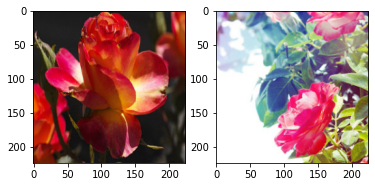

2 random images for code F2


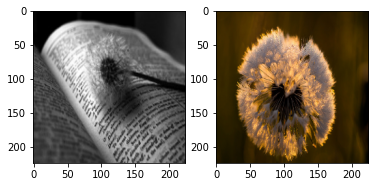

c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 2.7196738719940186 seconds


c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 3.713406562805176 seconds


c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 9.916503429412842 seconds
Training took 0.07650160789489746 seconds


c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.07031083106994629 seconds
Training took 0.06113600730895996 seconds
Training took 0.08066463470458984 seconds
Training took 0.08144116401672363 seconds
Training took 0.07130742073059082 seconds
KMeans VGG16: 
      0    1
F3  118   36
F2   17  149

KMeans VGG16 (PCA): 
      0    1
F3  118   36
F2   17  149

GMM VGG16: 
      0    1
F3   31  123
F2  133   33

KMeans VGG19: 
     0   1
F3  59  95
F2  98  68

KMeans VGG19 (PCA): 
     0   1
F3  59  95
F2  98  68
GMM VGG19 (PCA): 
      0    1
F3  128   26
F2   25  141
KMeans Resnet50: 
     0    1
F3  60   94
F2  18  148
Kmeans Resnet50 (PCA): 
     0    1
F3  60   94
F2  18  148
GMM Resnet50 (PCA): 
     0    1
F3  56   98
F2  17  149


In [43]:
codes = ["F2", "F3"]
outputs = image_load_to_cluster_count(codes)

In [44]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg16_cluster_code = ["F3", "F2"]
vgg16_cluster_code_pca = ["F3", "F2"]

vgg19_cluster_code = ["F3", "F2"]
vgg19_cluster_code_pca = ["F3", "F2"]
g_vgg19_cluster_code_pca = ["F3", "F2"]


vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in outputs[1]]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
vgg19_pred_codes_pca = [vgg19_cluster_code_pca[x] for x in outputs[3]]
g_vgg19_pred_codes_pca = [g_vgg19_cluster_code_pca[x] for x in outputs[4]]

print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))
print("GMM VGG19 (PCA)", print_scores(outputs[-1], g_vgg19_pred_codes_pca))


KMeans VGG16: 
	F1 Score: 0.83280592   |   Accuracy: 0.83280592
KMeans VGG16 (PCA) 
	F1 Score: 0.83280592   |   Accuracy: 0.83280592

KMeans VGG19:  
	F1 Score: 0.39639754   |   Accuracy: 0.39639754
KMeans VGG19 (PCA):  
	F1 Score: 0.39639754   |   Accuracy: 0.39639754
GMM VGG19 (PCA) 
	F1 Score: 0.84036153   |   Accuracy: 0.84036153


400 400
2 random images for code F5


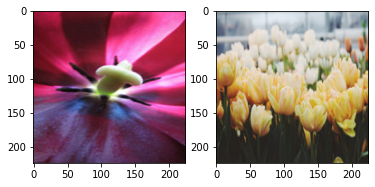

2 random images for code F4


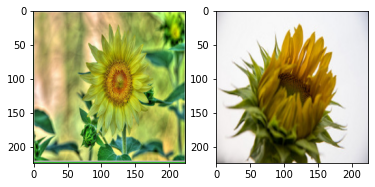

c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 2.5528509616851807 seconds


c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 2.412158250808716 seconds


c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 12.332154750823975 seconds
Training took 0.07093071937561035 seconds


c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
c:\users\ashish\appdata\local\programs\python\python38\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


Training took 0.06969761848449707 seconds
Training took 0.07923245429992676 seconds
Training took 0.08974218368530273 seconds
Training took 0.07851219177246094 seconds
Training took 0.07072997093200684 seconds
KMeans VGG16: 
     0   1
F5  87  67
F4  85  81

KMeans VGG16 (PCA): 
     0   1
F5  87  67
F4  85  81

GMM VGG16: 
     0   1
F5  87  67
F4  85  81

KMeans VGG19: 
     0    1
F5  25  129
F4  78   88

KMeans VGG19 (PCA): 
     0    1
F5  25  129
F4  78   88
GMM VGG19 (PCA): 
     0   1
F5  68  86
F4  70  96
KMeans Resnet50: 
      0   1
F5  116  38
F4  130  36
Kmeans Resnet50 (PCA): 
      0   1
F5  116  38
F4  130  36
GMM Resnet50 (PCA): 
      0   1
F5  113  41
F4  125  41


In [45]:
codes = ["F4", "F5"]
outputs = image_load_to_cluster_count(codes)

In [46]:
# Manually adjust these lists so that the index of each label reflects which cluter it lies in
vgg19_cluster_code = ["F4", "F5"]
vgg19_cluster_code_pca = ["F4","F5"]

In [47]:
# Let's define a function for scores

# def scoring(vgg16_cluster_code, vgg19_cluster_code, outputs):
#     vgg16_pred_codes = [vgg16_cluster_code[x] for x in outputs[0]]
#     vgg16_pred_codes_pca = [vgg16_cluster_code[x] for x in outputs[1]]
vgg19_pred_codes = [vgg19_cluster_code[x] for x in outputs[2]]
vgg19_pred_codes_pca = [vgg19_cluster_code[x] for x in outputs[3]]

#     print("KMeans VGG16:", print_scores(outputs[-1], vgg16_pred_codes))
#     print("KMeans VGG16 (PCA)", print_scores(outputs[-1], vgg16_pred_codes_pca))

print("\nKMeans VGG19: ", print_scores(outputs[-1], vgg19_pred_codes))
print("KMeans VGG19 (PCA): ", print_scores(outputs[-1], vgg19_pred_codes_pca))


KMeans VGG19:  
	F1 Score: 0.63767172   |   Accuracy: 0.63767172
KMeans VGG19 (PCA):  
	F1 Score: 0.63767172   |   Accuracy: 0.63767172
